## Longitudinal choice model
Description and examples: https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-discrete-choice_models.html#the-basic-model

In [1]:
# ------------------------------------------------------------------
# Load Libraries & Data
# ------------------------------------------------------------------
import os
os.environ['PYTENSOR_FLAGS'] = 'cxx=C:/msys64/ucrt64/bin/g++.exe,optimizer=fast_compile'
import importlib

import pymc as pm
import arviz as az

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.serif': ['STIXGeneral'], # latex-style font
    'mathtext.fontset': 'stix',
        'axes.labelsize': 11,
    'axes.titlesize': 12,
    'font.size': 11,
    'legend.fontsize': 11,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11
})

import f_data_processing as dp
dp = importlib.reload(dp)

print(os.getcwd())

print(pm.__name__, pm)

c:\Users\stdt\ETH Zurich\PhD Veronika - 07_Master Thesis Natalie\10_hcm_code\natural_hazard_solidarity
pymc <module 'pymc' from 'c:\\Users\\stdt\\ETH Zurich\\PhD Veronika - 07_Master Thesis Natalie\\10_hcm_code\\.venv\\lib\\site-packages\\pymc\\__init__.py'>


In [3]:
# prepare dummies without baseline in data for model
# load preprocessed data
df = pd.read_csv('../results/conjoint_df.csv', index_col=0)

attr_cols = ['costs', 'exemptions', 'benefits']
baselines = {'costs': 'All people pay the same amount', 'exemptions': 'No groups exempted from costs', 'benefits': 'Equal protection levels for all municipalities'}
for a in attr_cols:
    unique_levels = df[a].dropna().unique()
    cats = [baselines[a]] + [lvl for lvl in unique_levels if lvl != baselines[a]]
    df[a] = pd.Categorical(df[a], categories=cats)
    
def effects_code(attr_levels: pd.Series, baseline) -> pd.DataFrame:
    levels = list(attr_levels.cat.categories)
    nonbase = [lvl for lvl in levels if lvl != baseline]

    X = np.zeros((len(attr_levels), len(nonbase)), dtype=int)
    for j, lvl in enumerate(nonbase):
        X[:, j] = (attr_levels.values == lvl).astype(int)

    # Baseline: -1 in all columns
    base_mask = (attr_levels.values == baseline)
    X[base_mask, :] = -1

    # WICHTIG: Namensschema wie vorher (prefix_group + "_")
    cols = [f"{attr_levels.name}_{lvl}" for lvl in nonbase]
    return pd.DataFrame(X, columns=cols, index=attr_levels.index)

df_num = pd.concat([effects_code(df[a], baselines[a]) for a in attr_cols], axis=1)

In [4]:
# build task id
task_key = ['respondent_id', 'nh_event', 'task']
df['task_id'] = pd.factorize(df[task_key].apply(tuple, axis=1))[0]

# sort, so both, left and right option have same order
df = df.sort_values(['task_id', 'option']).copy()

# define right and left options
left_option  = 1
right_option = 2
left_mask  = df['option'] == left_option
right_mask = df['option'] == right_option

# check: per taks two rows with only one of them being chosen
counts = df.groupby('task_id').size()
print(counts)
assert (counts == 2).all(), 'Es gibt Tasks, die nicht genau 2 Alternativen haben.'
chosen_sum = df.groupby('task_id')['chosen'].sum()
assert (chosen_sum == 1).all(), 'Es gibt Tasks, bei denen chosen nicht genau einmal 1 ist.'

# X-matrices
X_left  = df_num.loc[left_mask].to_numpy()
X_right = df_num.loc[right_mask].to_numpy()

# observing, which option was chosen? was it left?
y_left = df.loc[left_mask, 'chosen'].to_numpy().astype(int)
event  = df.loc[left_mask, 'nh_event'].to_numpy().astype(int)

n_tasks = X_left.shape[0]

# individualisieren
resp_idx, resp_ids = pd.factorize(df.loc[left_mask, 'respondent_id'])
n_resp = len(resp_ids)

coords = {
    'level': df_num.columns.values,
    'task': np.arange(X_left.shape[0]),
    'respondent': np.arange(n_resp),
    'time': ['pre', 'post']
}

task_id
0       2
1       2
2       2
3       2
4       2
       ..
7540    2
7541    2
7542    2
7543    2
7544    2
Length: 7545, dtype: int64


In [5]:
# neue Version
with pm.Model(coords=coords) as longitudinal_model:
    Xl = pm.Data('X_left',  X_left,  dims=('task', 'level'))
    Xr = pm.Data('X_right', X_right, dims=('task', 'level'))
    y  = pm.Data('y_left',  y_left,  dims='task')
    e  = pm.Data('event',   event,   dims='task')

    beta  = pm.Normal('beta', 0, 1, dims='level')   # pre
    delta = pm.Normal('delta', 0, 1, dims='level')  # shift post-pre

    beta_eff = beta + delta * e[:, None]

    u_left  = pm.Deterministic('u_left',  pm.math.sum(Xl * beta_eff, axis=1), dims='task')
    u_right = pm.Deterministic('u_right', pm.math.sum(Xr * beta_eff, axis=1), dims='task')

    logit_p_left = pm.Deterministic('logit_p_left', u_left - u_right, dims='task')
    choice = pm.Bernoulli('choice', logit_p=logit_p_left, observed=y, dims='task')

    beta_post = pm.Deterministic('beta_post', beta + delta, dims='level')


In [6]:
# model test better approximation
with longitudinal_model:
    # idata_mcmc_with_base = pm.sample(draws=500, tune=500, chains=4, cores = 4, target_accept=0.9, progressbar=True)
    idata_mcmc = pm.sample(draws=500, tune=500, chains=4, cores = 4, target_accept=0.9, progressbar=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, delta]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 316 seconds.


In [7]:
# Summary for non baseline levels
summ_pre  = az.summary(idata_mcmc, var_names=['beta'],      hdi_prob=0.95).reset_index()
summ_post = az.summary(idata_mcmc, var_names=['beta_post'], hdi_prob=0.95).reset_index()

summ_pre  = dp.tidy(summ_pre,  'beta')
summ_post = dp.tidy(summ_post, 'beta_post')

# also draw baseline level summary from posterior
beta_da      = idata_mcmc.posterior['beta']       # dims: chain, draw, level
beta_post_da = idata_mcmc.posterior['beta_post']  # dims: chain, draw, level

def baseline_da_for_group(group):
    cols = [c for c in df_num.columns if c.startswith(f"{group}_")]  # nonbaseline columns
    base_pre  = -beta_da.sel(level=cols).sum('level')        # chain,draw
    base_post = -beta_post_da.sel(level=cols).sum('level')   # chain,draw
    return base_pre, base_post

baseline_rows_pre, baseline_rows_post = [], []

for g, name in baselines.items():
    base_pre, base_post = baseline_da_for_group(g)

    s_pre  = az.summary(base_pre,  hdi_prob=0.95).iloc[0]
    s_post = az.summary(base_post, hdi_prob=0.95).iloc[0]

    # Wichtig: level_raw muss zu deinem Parsing passen:
    # Du nutzt später level_raw wie "costs_<label>".
    level_raw = f"{g}_{name}"

    baseline_rows_pre.append({
        'level_raw': level_raw, 'group': g, 'label': name,
        'mean': float(s_pre['mean']), 'sd': float(s_pre['sd']),
        'hdi_2.5%': float(s_pre['hdi_2.5%']), 'hdi_97.5%': float(s_pre['hdi_97.5%'])
    })
    baseline_rows_post.append({
        'level_raw': level_raw, 'group': g, 'label': name,
        'mean': float(s_post['mean']), 'sd': float(s_post['sd']),
        'hdi_2.5%': float(s_post['hdi_2.5%']), 'hdi_97.5%': float(s_post['hdi_97.5%'])
    })

# add baseline to main-summary
summ_pre  = pd.concat([summ_pre,  pd.DataFrame(baseline_rows_pre)],  ignore_index=True)
summ_post = pd.concat([summ_post, pd.DataFrame(baseline_rows_post)], ignore_index=True)

# Merge wie bei dir
summ = summ_pre.merge(
    summ_post[['level_raw','mean','hdi_2.5%','hdi_97.5%']],
    on='level_raw',
    suffixes=('_pre','_post')
)
summ

,index,mean_pre,sd,hdi_2.5%_pre,hdi_97.5%_pre,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,level_raw,group,label,mean_post,hdi_2.5%_post,hdi_97.5%_post
0,beta[costs_People pay proportionally to their ...,0.162,0.054,0.059,0.272,0.001,0.001,1922.0,1417.0,1.0,costs_People pay proportionally to their income,costs,People pay proportionally to their income,0.084,0.007,0.174
1,beta[costs_People pay proportionally to their ...,-0.322,0.057,-0.443,-0.218,0.001,0.001,1908.0,1532.0,1.0,costs_People pay proportionally to their CO2 e...,costs,People pay proportionally to their CO2 emissions,-0.171,-0.264,-0.084
2,beta[costs_Companies pay proportionally to the...,0.249,0.065,0.129,0.384,0.001,0.001,1929.0,1371.0,1.0,costs_Companies pay proportionally to their CO...,costs,Companies pay proportionally to their CO2 emis...,0.312,0.212,0.417
3,beta[costs_People & companies being protected ...,0.256,0.056,0.154,0.369,0.001,0.001,1849.0,1594.0,1.0,costs_People & companies being protected by pr...,costs,People & companies being protected by protecti...,0.088,-0.006,0.178
4,beta[exemptions_Low-income earners exempted fr...,0.244,0.044,0.161,0.330,0.001,0.001,1805.0,1778.0,1.0,exemptions_Low-income earners exempted from costs,exemptions,Low-income earners exempted from costs,0.205,0.130,0.276
5,beta[exemptions_Low- and middle-income earners...,0.140,0.042,0.065,0.227,0.001,0.001,1800.0,1489.0,1.0,exemptions_Low- and middle-income earners exem...,exemptions,Low- and middle-income earners exempted from c...,0.130,0.059,0.195
6,beta[benefits_Municipalities most affected by ...,0.556,0.055,0.447,0.658,0.001,0.001,1954.0,1496.0,1.0,benefits_Municipalities most affected by natur...,benefits,Municipalities most affected by natural hazard...,0.412,0.326,0.503
7,beta[benefits_Municipalities in which people h...,-0.007,0.054,-0.111,0.099,0.001,0.001,1930.0,1387.0,1.0,benefits_Municipalities in which people have l...,benefits,Municipalities in which people have lived in f...,0.078,-0.007,0.158
8,beta[benefits_Economically prosperous municipa...,-0.823,0.058,-0.933,-0.708,0.001,0.001,1883.0,1442.0,1.0,benefits_Economically prosperous municipalities,benefits,Economically prosperous municipalities,-0.688,-0.782,-0.605
9,beta[benefits_Culturally valuable municipaliti...,-0.038,0.055,-0.139,0.073,0.001,0.001,1877.0,1570.0,1.0,benefits_Culturally valuable municipalities e....,benefits,Culturally valuable municipalities e.g. with h...,-0.074,-0.154,0.014


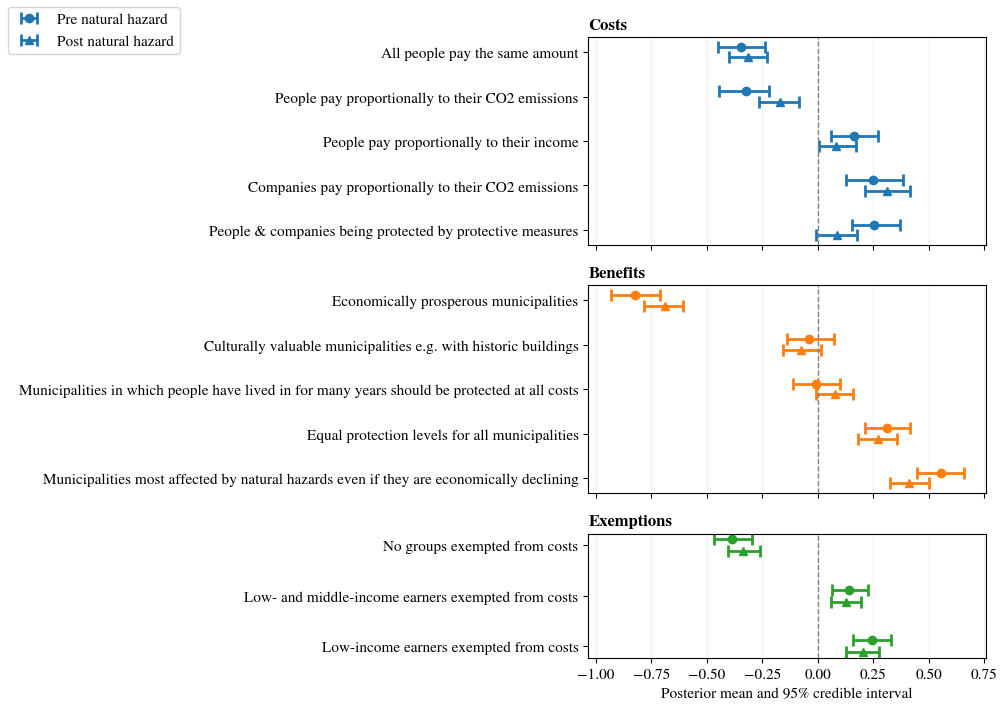

In [9]:
groups = ['costs', 'benefits', 'exemptions']
titles = {'costs':'Costs', 'benefits':'Benefits', 'exemptions':'Exemptions'}
color_map = {'costs':'tab:blue', 'benefits':'tab:orange', 'exemptions':'tab:green'}

# common coherent x limits for clear visualization
xmin = min(summ['hdi_2.5%_pre'].min(),  summ['hdi_2.5%_post'].min()) - 0.1
xmax = max(summ['hdi_97.5%_pre'].max(), summ['hdi_97.5%_post'].max()) + 0.1

# depending on number of attribute levels
heights = [max(1.4, 0.55 * len(summ[summ['group'] == g])) for g in groups]
offset = 0.12  # vertical separation between pre/post

fig, axes = plt.subplots(
    nrows=3, ncols=1, sharex=True,
    figsize=(10, sum(heights)),
    gridspec_kw={'height_ratios': heights}
)

for ax, g in zip(axes, groups):
    # sort by pre mean
    d = summ[summ['group'] == g].copy()
    d = d.sort_values('mean_pre')

    y0 = np.arange(len(d))[::-1].astype(float)
    y_pre  = y0 + offset
    y_post = y0 - offset
    c = color_map[g]

    # pre
    xerr_pre = np.vstack([d['mean_pre'] - d['hdi_2.5%_pre'], d['hdi_97.5%_pre'] - d['mean_pre']])
    ax.errorbar(d['mean_pre'], y_pre, xerr=xerr_pre, fmt='o', color=c, ecolor=c, elinewidth=2, capsize=4, capthick=2, label='Pre')

    # post
    xerr_post = np.vstack([d['mean_post'] - d['hdi_2.5%_post'], d['hdi_97.5%_post'] - d['mean_post']])
    ax.errorbar(d['mean_post'], y_post, xerr=xerr_post, fmt='^', color=c, ecolor=c, elinewidth=2, capsize=4, capthick=2, label='Post')

    ax.axvline(0, ls='--', lw=1, color='gray')
    ax.set_yticks(y0)
    ax.set_yticklabels(d['label'])
    ax.set_title(titles[g], loc='left', fontweight='bold')
    ax.grid(axis='x', alpha=0.2)
    ax.set_xlim(xmin, xmax)

# one legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles[:2], ['Pre natural hazard', 'Post natural hazard'], loc='upper left')
axes[-1].set_xlabel('Posterior mean and 95% credible interval')
plt.tight_layout()
plt.savefig(f'../results/longitudinal-choice-model.png', dpi=600)



In [ ]:
# model run
with longitudinal_model:
    idata = pm.sample(
        draws = 1000, 
        tune = 500, 
        chains = 4,
        cores = 4, 
        random_seed = 42, 
        return_inferencedata = True, 
        target_accept = 0.9, 
        progressbar=True
    )